
# Import Libraries

First, we import the required libraries as follows:

In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler # for normalizing our data (scalling)

import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf # for LSTM implementation
tf.logging.set_verbosity(tf.logging.ERROR) # it will log errors if occured

from google.colab import files
import io
uploaded = files.upload() # upload dataset file from local machine

## Data Preparation 

We will see how can we prepare our dataset in a way that LSTM needs. First, we read the input dataset:

In [96]:
dataframe = pd.read_csv(io.BytesIO(uploaded['bitcoin_data.csv']))

# Display a few rows of the dataset as follows:
dataframe.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


As shown in the above data frame, the column Close represents the closing price of bitcoins. We need only the column Close to make predictions, so we take that particular column alone as follows:

In [98]:
dataClose = dataframe['Close'].values

# Next, we standardize the data and bring it to the same scale
scaler = StandardScaler()
dataClose = scaler.fit_transform(dataClose.reshape(-1, 1)) # fit to data, thrn transform it for LSTM functions
dataClose

array([[ 1.32443891],
       [ 1.30836052],
       [ 1.34137813],
       ...,
       [-0.56145134],
       [-0.56145134],
       [-0.56356379]])

Plot and observe the trend of how the bitcoins price changes as follows, Since we scaled the price, it is not a bigger number:

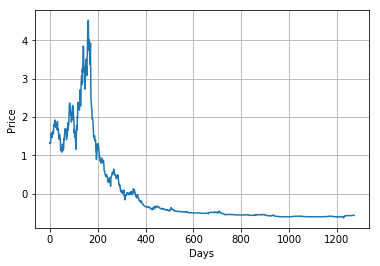

In [99]:
plt.plot(dataClose)
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid()

We define a function called get_data which generates the input and output. It takes the data and window_size as an input and generates the input and target column.

What is window size? We move the x values window_size times ahead and get the y values. For instance, as shown in the below table with window_size = 1, Y values are just 1-time step ahead of x values.

X = 0.13, 0.56, 0.11, 0.40

Y = 0.56, 0.11, 0.40, 0.63

The get_data() function is defined as follows: 

In [0]:
def get_data(data, window_size):
    X = []
    y = []
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y


We choose window size as 7 and generate the input and output:

In [0]:
X, y = get_data(dataClose, window_size = 7)

Consider the first 1000 points as a train set and the rest of the points in the dataset as the test set:

In [100]:
#train set, first 1000 values
X_train  = np.array(X[:1000]) 
y_train = np.array(y[:1000])

#test set, last 273 values
X_test = np.array(X[1000:])
y_test = np.array(y[1000:])

# The shape of X_train is shown:
X_train.shape

(1000, 7, 1)


What does the preceding shape mean? It implies that (sample_size, time_steps, features). LSTM requires input exactly in this format, for example:

* 1000 implies the number of data points (sample_size)

* 7 specifies the window size (time_steps) 

* 1 specifies the dimension of our dataset (features) 

## Defining Network Parameters

Define the network parameters:

In [0]:
batch_size = 7
window_size = 7 
hidden_layer = 256 
learning_rate = 0.001 

## Defining Placeholders

Define the placeholders for our input and output:

In [0]:
inputPlaceholder = tf.placeholder(tf.float32, [batch_size, window_size, 1])
outputPlaceholder = tf.placeholder(tf.float32, [batch_size, 1])

## Defining weights

Let's define all the weights we use in our LSTM cell.

In [0]:
# Weights of the input gate:
U_i = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_i = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_i = tf.Variable(tf.zeros([hidden_layer]))

# Weights of the forget gate:
U_f = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_f = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_f = tf.Variable(tf.zeros([hidden_layer]))

# Weights of the output gate:
U_o = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_o = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_o = tf.Variable(tf.zeros([hidden_layer]))

# Weights of the candidate state:
U_g = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_g = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_g = tf.Variable(tf.zeros([hidden_layer]))

# Output layer weight:
V = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
b_v = tf.Variable(tf.zeros([1]))

## Define the LSTM cell



We define the function called LSTM_cell, which returns the cell state and hidden state as an output. Recall the steps we saw in the forward propagation of LSTM:

 $$ i_t = \sigma ( U_i x_t + W_f h_{t-1} + b_i)  $$

$$ f_t = \sigma ( U_f x_t + W_f h_{t-1} + b_f)  $$

$$  o_t = \sigma (U_o x_t + W_o h_{t-1} + b_o)  $$

$$ g_t  = tanh (U_g x_t + W_g h_{t-1} + b_g)  $$

$$ c_t = f_t  c_{t-1} + i_t {g_t}  $$

$$ h_t = o_t tanh(c_t)  $$

The LSTM cell is implemented as shown in the following code. It takes the input, previous hidden state, and previous cell state as inputs, and returns the current cell state and current hidden state.

In [0]:
def LSTM_cell(inputPlaceholder, prev_hidden_state, prev_cell_state):
    input_gate = tf.sigmoid(tf.matmul(inputPlaceholder, U_i) + tf.matmul(prev_hidden_state, W_i) + b_i)
    forget_gate = tf.sigmoid(tf.matmul(inputPlaceholder, U_f) + tf.matmul(prev_hidden_state, W_f) + b_f)
    output_gate = tf.sigmoid(tf.matmul(inputPlaceholder, U_o) + tf.matmul(prev_hidden_state, W_o) + b_o)
    memory_cell = tf.tanh(tf.matmul(inputPlaceholder, U_g) + tf.matmul(prev_hidden_state, W_g) + b_g)
    
    state = (prev_cell_state * forget_gate) + (input_gate * memory_cell)
    output = output_gate * tf.tanh(state)
    
    return state, output

## Defining forward propagation


Now, we will perform forward propagation and predict the output, $\hat{y}_t$. 

$$ \hat{y}_t = Vh_t + b_v$$

In [0]:
#initialize the list called y_hat for storing the predicted output
y_hat = []

#for each batch we compute the output and store it in the y_hat list
for i in range(batch_size): 
  
    #initialize hidden state and cell state for each batch
    hidden_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    cell_state = np.zeros([1, hidden_layer], dtype=np.float32)
    
    
    #compute the hidden state and cell state of the LSTM cell for each time step
    for t in range(window_size):
        cell_state, hidden_state = LSTM_cell(tf.reshape(inputPlaceholder[i][t], (-1, 1)), hidden_state, cell_state)
        
    #compute y_hat and append it to y_hat list
    y_hat.append(tf.matmul(hidden_state, V) + b_v)

## Defining backpropagation

After performing forward propagation and predicting the output, we compute the loss. We use mean squared error as our loss function and the total loss is the sum of losses across all the time steps as follows:

In [0]:
losses = []

for i in range(len(y_hat)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(outputPlaceholder[i], (-1, 1)), y_hat[i]))
    
loss = tf.reduce_mean(losses)

To avoid the exploding gradient problem, we perform gradient clipping:

In [0]:
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, 4.0)

We use Adam optimizer and minimize our loss function:

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate).apply_gradients(zip(gradients, tf.trainable_variables()))

## Training the LSTM model


Start the TensorFlow session and initialize all the variables:

In [0]:
session = tf.Session()
session.run(tf.global_variables_initializer())

Set the number of epochs:

In [0]:
epochs = 100

In [72]:
for i in range(1, epochs+1):
    train_predictions = []
    index = 0
    epoch_loss = []
    
    #Sample some batche of data and train the network
    while(index + batch_size) <= len(X_train):
        
        #sample batch of data
        X_batch = X_train[index:index+batch_size]
        y_batch = y_train[index:index+batch_size]
        
        #predict the prices and compute loss
        predicted, loss_val, _ = session.run([y_hat, loss, optimizer], feed_dict={inputPlaceholder:X_batch, outputPlaceholder:y_batch})
        
        #store the loss
        epoch_loss.append(loss_val)
        
        #store the predictions
        train_predictions.append(predicted)
        index += batch_size
        
        
    #print the loss on every 10 iterations
    if (i % 10)== 0:
        print('Epoch {}, Loss: {} '.format(i,np.mean(epoch_loss)))
        

Epoch 0, Loss: 0.1974003165960312 
Epoch 10, Loss: 0.04612082988023758 
Epoch 20, Loss: 0.026473088189959526 
Epoch 30, Loss: 0.016945650801062584 
Epoch 40, Loss: 0.011989578604698181 
Epoch 50, Loss: 0.01603507809340954 
Epoch 60, Loss: 0.008690208196640015 
Epoch 70, Loss: 0.01041472889482975 
Epoch 80, Loss: 0.009024037048220634 
Epoch 90, Loss: 0.00800042599439621 


## Making predictions using the LSTM model

Now, we will start making predictions on the test set.

In [0]:
predicted_output = []
i = 0
while i+batch_size <= len(X_test): 
  
    output = session.run([y_hat],feed_dict={inputPlaceholder:X_test[i:i+batch_size]})
    i += batch_size
    predicted_output.append(output)

Print the predicted output

In [74]:
predicted_output[0]

[[array([[-0.6051648]], dtype=float32),
  array([[-0.60201555]], dtype=float32),
  array([[-0.6010114]], dtype=float32),
  array([[-0.60018414]], dtype=float32),
  array([[-0.59972805]], dtype=float32),
  array([[-0.6015558]], dtype=float32),
  array([[-0.59730077]], dtype=float32)]]

As you can see above, the predicted values are in a nested list. So we will just flatten them.

In [0]:
predicted_values_test = []
for i in range(len(predicted_output)):
    for j in range(len(predicted_output[i][0])):
        predicted_values_test.append(predicted_output[i][0][j])

Now if we print the predicted values, it is no longer in a nested list

In [76]:
predicted_values_test[0]

array([[-0.6051648]], dtype=float32)

As we took the first 1000 points as a training set, we make predictions for time step greater
than 1000.

In [0]:
predictions = []
for i in range(1280):
    if i >= 1000:
        predictions.append(predicted_values_test[i-1019])
    else:
        predictions.append(None)

Plot and see how well the predicted value matches the actual value:



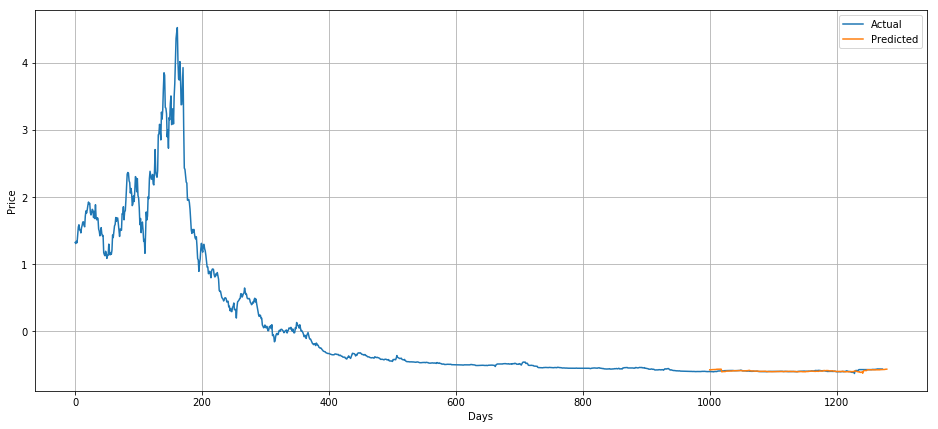

In [79]:
plt.figure(figsize=(16, 7))
plt.plot(dataClose, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid()
plt.show()

As you can see in the above plot, the actual value is shown in red color and the predicted value is shown in blue color. As we are making predictions for the time step greater than 1000, you can see after the time step 1000, red and blue lines interest each other, which implies that our model has correctly predicted the actual values.

In the next section, we will learn about the GRU cell which acts as a simplified version of GRU cell.